## Week 12 Homework (10)

### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

A stochastis process is a collection of random variables indexed by time, space, or any other set. A Gaussian Process is a type of stochastic process where any finite set of points has a joint multivariate normal distribution. It defines a distribution over functions, not just over finite-dimensional variables.

$$f(x)∼GP(m(x),k(x,x′))$$

where $m(x)$ is the mean, and $k(x, x')$ is the kernel function

Variational Inference is a technique to approximate intractable posterior distribution by finding a simpler distribution that is closest to the true posterior. Because the marginal likelihood is hard to compute directly, we instead maximize a lower bound on log ot he marginal likelihood called the ELBO, hence maximizing ELBO is equivalent to minimizing the KL divergence between the simpler distribution and the true posterior.


### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

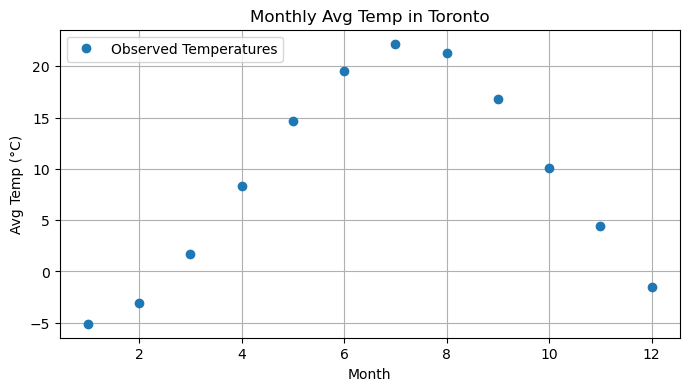

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# Example dataset: average Toronto monthly temperatures (°C)
months = np.arange(1, 13)
temps = np.array([-5.1, -3.1, 1.7, 8.3, 14.7, 19.5, 22.2, 21.3, 16.8, 10.1, 4.4, -1.5])  # avg monthly temps

x = months[:, None] / 12.0
y = temps

plt.figure(figsize=(8, 4))
plt.plot(months, temps, "o", label="Observed Temperatures")
plt.xlabel("Month")
plt.ylabel("Avg Temp (°C)")
plt.title("Monthly Avg Temp in Toronto")
plt.grid(True)
plt.legend()
plt.show()

with pm.Model() as gp_model:
    mean_func = pm.gp.mean.Zero()
    cov_func = pm.gp.cov.ExpQuad(1, ls=0.3)
    gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
    sigma = pm.HalfNormal("sigma", sigma=5)
    y_ = gp.marginal_likelihood("y", X=x, y=y, noise=sigma)
    trace = pm.sample(1000, chains=2, target_accept=0.9)

x_pred = np.linspace(0, 1, 100)[:, None]

with gp_model:
    f_pred = gp.conditional("f_pred", Xnew=x_pred)
    f_samples = pm.draw(f_pred, draws=1000, random_seed=42)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])

f_pred_mean = f_samples.mean(axis=0)
f_pred_hpd = az.hdi(f_samples, hdi_prob=0.94)

plt.figure(figsize=(8, 4))
plt.plot(months, temps, "o", label="Observed")
plt.plot(x_pred.flatten() * 12, f_pred_mean, label="GP Mean")
plt.fill_between(x_pred.flatten() * 12, f_pred_hpd[:, 0], f_pred_hpd[:, 1], alpha=0.3, label="94% HDI")
plt.xlabel("Month")
plt.ylabel("Avg Temp (°C)")
plt.title("GP Fit to Monthly Temperature in Toronto")
plt.legend()
plt.grid(True)
plt.show()



### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name']
df = pd.read_csv(url, delim_whitespace=True, names=columns, na_values='?')
df = df.dropna()

X = df[['horsepower', 'weight', 'acceleration']].values
y = df['mpg'].values

# Standardize
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define Bayesian neural network
with pm.Model() as neural_net_vi:
    # Layer 1
    weights_in_1 = pm.Normal("w_in_1", mu=0, sigma=1, shape=(3, 10))
    bias_in_1 = pm.Normal("b_in_1", mu=0, sigma=1, shape=(10,))
    act_1 = pm.math.tanh(pm.math.dot(X_train, weights_in_1) + bias_in_1)

    # Output layer
    weights_2 = pm.Normal("w_2", mu=0, sigma=1, shape=(10,))
    bias_2 = pm.Normal("b_2", mu=0, sigma=1)
    mu = pm.math.dot(act_1, weights_2) + bias_2

    # Observation noise
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    approx = pm.fit(n=10000, method='advi')
    trace = approx.sample(1000)

w1 = trace.posterior["w_in_1"].mean(dim=("chain", "draw")).values
b1 = trace.posterior["b_in_1"].mean(dim=("chain", "draw")).values
w2 = trace.posterior["w_2"].mean(dim=("chain", "draw")).values
b2 = trace.posterior["b_2"].mean(dim=("chain", "draw")).values

# Forward pass manually using NumPy
act_1_test = np.tanh(np.dot(X_test, w1) + b1)
y_pred_scaled = np.dot(act_1_test, w2) + b2
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(scaler_y.inverse_transform(y_test.reshape(-1, 1)), y_pred, alpha=0.6)
plt.plot([10, 50], [10, 50], "--", color="gray")
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("BNN with VI on Auto MPG Dataset")
plt.grid(True)
plt.show()

